<a href="https://colab.research.google.com/github/anadebattista/TMnews/blob/master/TMnews_TopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the libraries

In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

Connect to drive to get the data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


---

Seteo de directorio de trabajo

---

In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Curso Mineria Textos 2019/data")

---

Importación de archivo de noticias (TMnews.csv)

---

In [0]:
import pandas as pd 
df_news = pd.read_csv('TMnews.csv')
df_news

,news_paper,category,date,titleandbody
0,clarin,deportes,2019-10-01,"“¿Por qué no te ponés a dieta?”, el escándalo ..."
1,clarin,deportes,2019-10-01,En España hablan de una fractura en el Barcelo...
2,clarin,deportes,2019-10-01,Superclásico: qué dicen los astros para el Riv...
3,clarin,deportes,2019-10-01,"River-Boca, por la Copa Libertadores: cómo est..."
4,clarin,deportes,2019-10-01,"El Mundial de atletismo, envuelto en el drama ..."
...,...,...,...,...
37389,lanacion,tecnologia,2019-10-29,Como una Z: así es el prototipo de TCL de un s...
37390,lanacion,tecnologia,2019-10-29,Lanzan una app gratis para ayudar a los partid...
37391,lanacion,tecnologia,2019-10-29,YouTube presenta su primera película interacti...
37392,lanacion,tecnologia,2019-10-29,Apple planea lanzar una función para crear Mem...


In [0]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37394 entries, 0 to 37393
Data columns (total 4 columns):
news_paper      37394 non-null object
category        37394 non-null object
date            37394 non-null object
titleandbody    37394 non-null object
dtypes: object(4)
memory usage: 1.1+ MB


---

**Data Preprocessing**

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

---

In [0]:
def cleaner(word):
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
  word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
  word = re.sub(r'ee.uu', 'eeuu', word)
  word = re.sub(r'\#\.', '', word)
  word = re.sub(r'\n', '', word)
  word = re.sub(r',', '', word)
  word = re.sub(r'\-', ' ', word)
  word = re.sub(r'\.{3}', ' ', word)
  word = re.sub(r'a{2,}', 'a', word)
  word = re.sub(r'é{2,}', 'é', word)
  word = re.sub(r'i{2,}', 'i', word)
  word = re.sub(r'ja{2,}', 'ja', word) 
  word = re.sub(r'á', 'a', word)
  word = re.sub(r'é', 'e', word)
  word = re.sub(r'í', 'i', word)
  word = re.sub(r'ó', 'o', word)
  word = re.sub(r'ú', 'u', word)  
  word = re.sub('[^a-zA-Z]', ' ', word)
  list_word_clean = []
  for w1 in word.split(" "):
    if  w1.lower() not in stopwords:
      list_word_clean.append(w1.lower())

  bigram_list = bigram[list_word_clean]
  out_text = lemmatization(" ".join(bigram_list))
  return out_text

Create the function for select only nouns for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

In [0]:
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in stopwords and len(token.text)>2]
    return texts_out

For gensim we need a list of text, so we need do convert the dataframe to list

In [0]:
#estaba to_list pero es tolist
len(df_news.titleandbody.tolist())

37394

Then we look for bigram in our data, i.e pair of words that together have more meanful for our model

In [7]:
%%time
bigram = gensim.models.Phrases(df_news.titleandbody.tolist())

NameError: ignored

Let's examine some output

In [0]:
bigram[df_news.titleandbody.tolist()[20].split()]

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['Copa',
 'del',
 'Mundo',
 'de',
 'vóleibol:',
 'Argentina',
 'debutó',
 'con',
 'un',
 'triunfo',
 'ante',
 'el',
 'último',
 'campeón',
 '//',
 'La',
 'Selección',
 'de',
 'vóleibol',
 'masculino',
 'tuvo',
 'un',
 'debut',
 'soñado',
 'este',
 'martes',
 'en',
 'la',
 'Copa',
 'del',
 'Mundo',
 'que',
 'se',
 'disputa',
 'en',
 'Japón',
 'al',
 'vencer',
 'por',
 '3-2',
 'al',
 'campeón',
 'defensor,',
 'Estados',
 'Unidos.',
 'El',
 'equipo',
 'de',
 'Marcelo',
 'Méndez',
 'tuvo',
 'un',
 'arranque',
 'inmejorable',
 'al',
 'ganar',
 'los',
 'dos',
 'primeros',
 'parciales',
 '25-21',
 'y',
 '25-20.',
 'Sin',
 'embargo,',
 'el',
 'conjunto',
 'estadounidense',
 'pudo',
 'reponerse',
 'e',
 'igualó',
 'el',
 'partido',
 'con',
 'los',
 'parciales',
 '19-25',
 'y',
 '21-25.',
 'Finalmente,',
 'el',
 'tie',
 'break,',
 'Argentina',
 'se',
 'impuso',
 '15-12.',
 'Recibir',
 'newsletter',
 'Los',
 'máximos',
 'anotadores',
 'de',
 'Argentina',
 'fueron',
 'Martín',
 'Ramos',
 '(20)',
 

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('spanish'))

#additional_stopwords=set(black_list)
#stopwords = stop.union(additional_stopwords)

We are using Spacy For lemmatize spanish words

In [10]:
!python -m spacy download es_core_news_md

     |████████████████████████████████| 73.4MB 982kB/s 
  Created wheel for es-core-news-md: filename=es_core_news_md-2.1.0-cp36-none-any.whl size=74602272 sha256=6e5f54edf69a21ab58efb1efc2df8d5f968790a56b06ce40f52fb9aa5d5b6847
  Stored in directory: /tmp/pip-ephem-wheel-cache-wjcjo6qt/wheels/20/f7/6b/7a1ba56f009b05386d123ea088b56635594a046acd5cfdd2a2
Successfully built es-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [0]:
import spacy
nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/es_core_news_md/es_core_news_md-2.1.0')

Now let's test the cleaner function:

In [0]:
df_news.titleandbody[0]

"['pones', 'dieta', 'pruebas', 'bermudez', 'ascenso', 'metro', 'cantante', 'temas', 'manuel', 'serrat', 'lunes', 'canto', 'situacion', 'cargo', 'secretario', 'asociacion', 'arbitros', 'federico', 'director', 'arbitraje', 'bermudez', 'envio', 'grupo', 'amigos', 'programa', 'closs', 'periodista', 'tema', 'irregularidades', 'pruebas', 'pelea', 'jugadores', 'beares', 'foto', 'marcelo', 'alados', 'bermudez', 'matias', 'arbitro', 'foto', 'enero', 'fisico', 'rosario', 'despues', 'partido', 'tomas', 'duco', 'ademas', 'reconocio', 'version', 'ropa', 'ayuda', 'arbitro', 'nestor', 'sector', 'banderita', 'testimonio', 'arbitro', 'prueba', 'tenia', 'cono', 'metros', 'manera', 'fisico', 'silueta', 'asistente', 'beares', 'apellido', 'nivel', 'arbitraje', 'futbol', 'arbitro', 'recorrido', 'ascenso', 'bermudez', 'hediondo', 'lopez', 'audio', 'colega', 'bermudez', 'foto', 'cono', 'lugar', 'beares', 'lopez', 'tono', 'punto', 'golpes', 'palabras', 'profes', 'cerro', 'juez', 'newsletter', 'audio', 'grupo',

In [0]:
cleaner(df_news.titleandbody[0])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['pones',
 'dieta',
 'pruebas',
 'bermudez',
 'ascenso',
 'metro',
 'cantante',
 'temas',
 'manuel',
 'serrat',
 'lunes',
 'canto',
 'situacion',
 'cargo',
 'secretario',
 'asociacion',
 'arbitros',
 'federico',
 'director',
 'arbitraje',
 'bermudez',
 'envio',
 'grupo',
 'amigos',
 'programa',
 'closs',
 'periodista',
 'tema',
 'irregularidades',
 'pruebas',
 'pelea',
 'jugadores',
 'beares',
 'foto',
 'marcelo',
 'alados',
 'bermudez',
 'matias',
 'arbitro',
 'foto',
 'enero',
 'fisico',
 'rosario',
 'despues',
 'partido',
 'tomas',
 'duco',
 'ademas',
 'reconocio',
 'version',
 'ropa',
 'ayuda',
 'arbitro',
 'nestor',
 'sector',
 'banderita',
 'testimonio',
 'arbitro',
 'prueba',
 'tenia',
 'cono',
 'metros',
 'manera',
 'fisico',
 'silueta',
 'asistente',
 'beares',
 'apellido',
 'nivel',
 'arbitraje',
 'futbol',
 'arbitro',
 'recorrido',
 'ascenso',
 'bermudez',
 'hediondo',
 'lopez',
 'audio',
 'colega',
 'bermudez',
 'foto',
 'cono',
 'lugar',
 'beares',
 'lopez',
 'tono',
 'pun

Let's clean all the text¶

In [0]:
df_news['titleandbody2'] = df_news['titleandbody']

In [0]:
%%time
df_news['titleandbody'] = df_news['titleandbody'].apply(cleaner)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 39min 37s, sys: 27.2 s, total: 40min 4s
Wall time: 40min 6s


---

Exporto el dataframe con la columna titleandbody limpia porque la ejecución de la función llevó 40 minutos!!!

---

In [0]:
news_Clean = df_news.to_csv (r'/content/drive/My Drive/Colab Notebooks/Curso Mineria Textos 2019/data/news_clean.csv', index = None, header=True)

Importo el CSV news_clean

In [12]:
import pandas as pd 
df_news = pd.read_csv('news_clean.csv')
df_news

,news_paper,category,date,titleandbody,titleandbody2
0,clarin,deportes,2019-10-01,"['pones', 'dieta', 'pruebas', 'bermudez', 'asc...","“¿Por qué no te ponés a dieta?”, el escándalo ..."
1,clarin,deportes,2019-10-01,"['espa', 'fractura', 'barcelona', 'lionel', 'm...",En España hablan de una fractura en el Barcelo...
2,clarin,deportes,2019-10-01,"['astros', 'boca', 'creyentes', 'ansiedad', 'i...",Superclásico: qué dicen los astros para el Riv...
3,clarin,deportes,2019-10-01,"['boca', 'copa', 'libertadores', 'hora', 'duel...","River-Boca, por la Copa Libertadores: cómo est..."
4,clarin,deportes,2019-10-01,"['atletismo', 'drama', 'deportistas', 'clima',...","El Mundial de atletismo, envuelto en el drama ..."
...,...,...,...,...,...
37389,lanacion,tecnologia,2019-10-29,"['prototipo', 'partes', 'dias', 'prototipo', '...",Como una Z: así es el prototipo de TCL de un s...
37390,lanacion,tecnologia,2019-10-29,"['app', 'partidos', 'elecciones', 'aplicacion'...",Lanzan una app gratis para ayudar a los partid...
37391,lanacion,tecnologia,2019-10-29,"['pelicula', 'finales', 'with', 'markiplier', ...",YouTube presenta su primera película interacti...
37392,lanacion,tecnologia,2019-10-29,"['apple', 'funcion', 'foto', 'ilustraciones', ...",Apple planea lanzar una función para crear Mem...


Now we need to build the corpus and the dictionary that gensim need to work, to do that we need to pass a list of list of tokens

In [0]:
from ast import literal_eval

tokens = df_news['titleandbody'].apply(literal_eval)
#type([tokens])

dictionary = Dictionary(tokens)
dictionary.compactify()
# Filter extremes
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(literal_eval(text)) for text in df_news['titleandbody']] #.tolist()



Now let's do the modeling part
We are comparing 3 topic modeling algorithm Latent Dirichlet Allocation (LDA), Latent semantic analysis (LSA), Hierarchical Dirichlet Process (HDP),in order to evaluate topic models we will be using topic coherence, which is a measure of how interpretable topics are for human beings.

Hierarchical Dirichlet process Model

In [0]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)

and the topics of this model:

In [0]:
def display_topics(model, model_type="lda"):
  for topic_idx, topic in enumerate(model.print_topics()):
    print ("Topic %d:" % (topic_idx))
    if model_type== "hdp":
      print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
    else:
      print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

In [16]:
# hdpmodel.show_topics() 

display_topics(hdpmodel, model_type="hdp")

Topic 0:
vez  millones  presidente  parte  gobierno  tiempo  personas  mundo  momento  caso 

Topic 1:
equipo  boca  partido  vez  tiempo  momento  vida  parte  mundo  futbol 

Topic 2:
vez  parte  tiempo  mundo  momento  personas  vida  juego  compa  historia 

Topic 3:
vez  partido  equipo  tiempo  historia  mundo  minutos  rugby  juego  inglaterra 

Topic 4:
equipo  partido  boca  libertadores  octubre  futbol  copa  tiempo  jugador  parte 

Topic 5:
elecciones  voto  octubre  equipo  presidente  millones  vez  gobierno  cambio  puntos 

Topic 6:
mundo  vez  historia  equipo  hijo  bezos  vida  tiempo  millones  temporada 

Topic 7:
partido  equipo  rugby  puntos  tiempo  francia  minutos  gol  parte  jugadores 

Topic 8:
millones  lacunza  partido  ministro  dolares  equipo  vez  puntos  ahorro  gobierno 

Topic 9:
alimentos  trabajo  mundo  millones  carne  futbol  boca  premio  juego  banco 

Topic 10:
minutos  equipo  partido  puntos  gol  vez  tiempo  juego  parte  patrick 

To

In [0]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

LSI MODEL

In [0]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [19]:
display_topics(lsimodel)  # Showing the topics

Topic 0:
vez tiempo presidente mundo parte millones gobierno vida momento gente 

Topic 1:
presidente gobierno millones candidato debate vida elecciones casa candidatos vez 

Topic 2:
millones debate presidente candidato dolares candidatos mercado boca partido empresas 

Topic 3:
boca equipo partido millones mujeres juego jugadores vida futbol copa 

Topic 4:
millones casa mundo gracias sistema mujeres paso juego hijo seguridad 

Topic 5:
millones gracias vida datos segundos tiempo minutos ciudad mundo derechos 

Topic 6:
mujeres encuentro boca tiempo casa plata juego sistema ciudad mujer 

Topic 7:
boca debate juego gobierno millones candidatos gracias libertadores historia seguridad 

Topic 8:
minutos gente mujeres cosas sinopsis casa direccion millones duracion mundo 

Topic 9:
minutos sinopsis direccion duracion debate boca casa litio calificacion agua 



It seen that with 10 topics there is some themes with keywords related to: trump, venezuela, police, electiones, terrorism; still is a little difficult to gt some insight, because of this we are trying to select the best number of topics by iterate over a range of values and looking the coherence

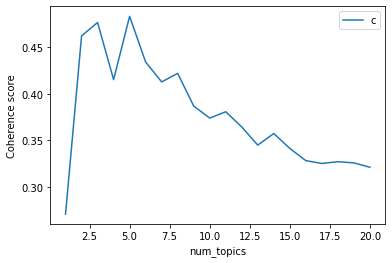

CPU times: user 20min 13s, sys: 21.3 s, total: 20min 34s
Wall time: 19min 19s


In [21]:
%%time
#lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['titleandbody'].tolist(), limit=21, model= "lsi")
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval), limit=21, model= "lsi")


According to the coherence the best number of topics are between 3-7, however you must select the topics using both the coherence and visual inspection.

In [22]:
display_topics(lmlist_lsi[2])

Topic 0:
vez tiempo presidente mundo parte millones gobierno vida momento gente 

Topic 1:
presidente gobierno millones candidato debate vida casa candidatos vez mauricio 

Topic 2:
millones presidente debate candidato dolares mercado gracias candidatos datos empresas 



Now, Let's try another model

Latent Dirichlet Allocation Model

In [0]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [24]:
display_topics(ldamodel)

Topic 0:
vida cosas vez momento tiempo gente casa familia veces mundo 

Topic 1:
samsung mano boca minutos vez tiempo equipo video litros chocolate 

Topic 2:
equipo juego partido equipos partidos jugadores minutos vez futbol tiempo 

Topic 3:
presidente candidato gobierno debate elecciones cambio mauricio candidatos fernandez alberto 

Topic 4:
sistema millones compa datos empresa servicio servicios dolares uso personas 

Topic 5:
mundo mujeres vez parte litio vida historia tiempo robot personas 

Topic 6:
millones mercado dolares robots nacion intel crecimiento cambio mundo empresas 

Topic 7:
pantalla personas videojuegos vez forma persona sistema usuario aplicaciones telefono 

Topic 8:
actriz semana actor grupo cancer temporada vez show momento pelicula 

Topic 9:
ciudad aires nacion justicia caso agua horas fuentes zona causa 



Find out the optimal number of topics for the LDA model based on the coherence metric:

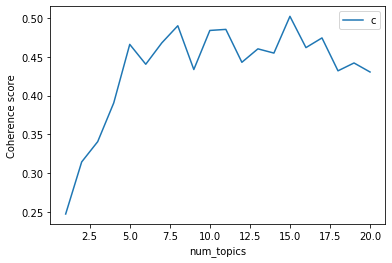

CPU times: user 30min 3s, sys: 13.8 s, total: 30min 17s
Wall time: 30min 2s


In [26]:
%%time
#lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['titleandbody'].tolist(), limit=21, model= "lda")
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval), limit=21, model= "lda")


For this model it seems that 9 or 18, again we must to check the keywords too.
Comparing the Model Coherence of the Best Models
we made 3 models, now let's compare each other's coherence

In [0]:
ldamodel = lmlist[11]
lsimodel = lmlist_lsi[2]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [0]:
#lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['titleandbody'].tolist(), dictionary=dictionary, window_size=10).get_coherence()

#hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['titleandbody'].tolist(), dictionary=dictionary, window_size=10).get_coherence()

#lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['titleandbody'].tolist(), dictionary=dictionary, window_size=10).get_coherence()

lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['titleandbody'].apply(literal_eval), dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['titleandbody'].apply(literal_eval), dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['titleandbody'].apply(literal_eval), dictionary=dictionary, window_size=10).get_coherence()

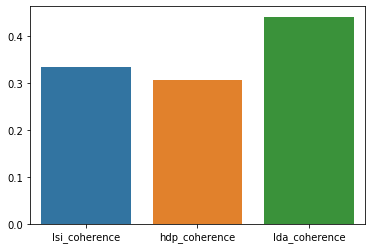

In [30]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence','hdp_coherence', 'lda_coherence']
sns.barplot(x, coherences)

Examine the keyword to get the topics of the best model

In [31]:
display_topics(ldamodel)

Topic 0:
presidente candidato gobierno elecciones debate mauricio cambio fernandez alberto candidatos 

Topic 1:
vez mundo serie personaje historia the parte podcast actriz tiempo 

Topic 2:
personas chile facebook semana mujeres red redes fin paro vuelos 

Topic 3:
casa mujer vez ana noche madre momento familia hijo dia 

Topic 4:
vida tiempo momento vez veces cosas samsung familia comida casa 

Topic 5:
sistema pantalla servicio compa uso forma datos telefono usuario vez 

Topic 6:
millones dolares empresas mercado empresa productos precio compa mes sector 

Topic 7:
universidad mundo personas estudio trabajo vez tipo ejemplo tierra parte 

Topic 8:
videojuegos grupo banda tiempo mundo vidas avion despues carne parte 

Topic 9:
juego equipo partido equipos jugadores futbol boca videojuego play vez 

Topic 10:
caso informes justicia nacion causa casos seguridad apple personas fuentes 

Topic 11:
ciudad obras obra aires nacion lugar mujeres parte grupo corte 



Let´s check the keyword when we selecting another number of topics (14)



In [0]:
ldamodel_16 =lmlist[16]

In [33]:
display_topics(ldamodel_16)

Topic 0:
mundo litio comida agua universidad personas desarrollo tierra ejemplo forma 

Topic 1:
sistema robots robot computadora forma investigadores estudio modelos tipo almacenamiento 

Topic 2:
facebook chile seguridad grupo personas medios ciudad caso derechos nacion 

Topic 3:
cosas gente vez tiempo veces momento mundo vida personas tenes 

Topic 4:
ciudad debate mujeres aires acto provincia personas gobierno gente nacion 

Topic 5:
partido equipo boca partidos minutos club vez libertadores tiempo juego 

Topic 6:
app cancer grupo utero tiempo pelicula mama banda incendio playstation 

Topic 7:
vez historia personaje mujeres serie podcast the actor play amor 

Topic 8:
one mate mundo mini wifi historia habilidades oct pdt hielo 

Topic 9:
agua actriz smartphones zona tiempo grados temperatura lluvias rugby maxima 

Topic 10:
millones mercado dolares empresas precio samsung empresa mes sector intel 

Topic 11:
caso justicia casos causa denuncia seguridad juicio investigacion polic

Classifiying all documents
now that we have been select the best model and topics number, is time to assign a topic to each document, means cluster according to the topics

In [0]:
def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['titleandbody'].apply(literal_eval))

In [60]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.4227,"caso, informes, justicia, nacion, causa, casos...","[pones, dieta, pruebas, bermudez, ascenso, met..."
1,1,9.0,0.5959,"juego, equipo, partido, equipos, jugadores, fu...","[espa, fractura, barcelona, lionel, messi, bar..."
2,2,9.0,0.7763,"juego, equipo, partido, equipos, jugadores, fu...","[astros, boca, creyentes, ansiedad, interes, a..."
3,3,9.0,0.5482,"juego, equipo, partido, equipos, jugadores, fu...","[boca, copa, libertadores, hora, duelo, ida, s..."
4,4,4.0,0.4995,"vida, tiempo, momento, vez, veces, cosas, sams...","[atletismo, drama, deportistas, clima, imagen,..."
5,5,9.0,0.7000,"juego, equipo, partido, equipos, jugadores, fu...","[goles, historial, martes, octubre, semifinal,..."
6,6,9.0,0.6222,"juego, equipo, partido, equipos, jugadores, fu...","[detras, escena, challenger, tenistas, circuit..."
7,7,4.0,0.4742,"vida, tiempo, momento, vez, veces, cosas, sams...","[alberto, entrenador, farah, reglas, atletismo..."
8,8,9.0,0.8872,"juego, equipo, partido, equipos, jugadores, fu...","[copa, mundo, voleibol, triunfo, campeon, vole..."
9,9,9.0,0.8575,"juego, equipo, partido, equipos, jugadores, fu...","[brise, santos, mexico, santos, desato, mexico..."


We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label

first let's create the dictionary

In [0]:
#label_dicc = {0:'trials', 1:'nature', 2:'violence', 3: 'protest', 4:'life_family', 5:'sea_disasters', 6:'elections', 7:'terrorism', 8:'economic_crisis', 9: 'seism', 10:'peacy_treaty', 11:'airport_security'}
label_dicc = {0:'elecciones', 1:'espectáculos', 2:'chile', 3: 'familia', 4:'deportes y ocio', 5:'tecnología', 6:'economía', 
              7:'estudio', 8:'jóvenes', 9: 'deportes y videojuegos', 10:'justicia', 11:'ciudad'}

In [0]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')

In [63]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,justicia,0.4227,"caso, informes, justicia, nacion, causa, casos...","[pones, dieta, pruebas, bermudez, ascenso, met..."
1,1,deportes y videojuegos,0.5959,"juego, equipo, partido, equipos, jugadores, fu...","[espa, fractura, barcelona, lionel, messi, bar..."
2,2,deportes y videojuegos,0.7763,"juego, equipo, partido, equipos, jugadores, fu...","[astros, boca, creyentes, ansiedad, interes, a..."
3,3,deportes y videojuegos,0.5482,"juego, equipo, partido, equipos, jugadores, fu...","[boca, copa, libertadores, hora, duelo, ida, s..."
4,4,deportes y ocio,0.4995,"vida, tiempo, momento, vez, veces, cosas, sams...","[atletismo, drama, deportistas, clima, imagen,..."
5,5,deportes y videojuegos,0.7000,"juego, equipo, partido, equipos, jugadores, fu...","[goles, historial, martes, octubre, semifinal,..."
6,6,deportes y videojuegos,0.6222,"juego, equipo, partido, equipos, jugadores, fu...","[detras, escena, challenger, tenistas, circuit..."
7,7,deportes y ocio,0.4742,"vida, tiempo, momento, vez, veces, cosas, sams...","[alberto, entrenador, farah, reglas, atletismo..."
8,8,deportes y videojuegos,0.8872,"juego, equipo, partido, equipos, jugadores, fu...","[copa, mundo, voleibol, triunfo, campeon, vole..."
9,9,deportes y videojuegos,0.8575,"juego, equipo, partido, equipos, jugadores, fu...","[brise, santos, mexico, santos, desato, mexico..."


In [0]:
df_news['Tópicos'] = df_dominant_topic['Dominant_Topic']

Let's examine some text and its topics

In [65]:
df_news[['titleandbody2', 'Tópicos']].head(30)
#df_news[['titleandbody2', 'Tópicos']][df_news['Tópicos']=='deportes'].head(50)

,titleandbody2,Tópicos
0,"“¿Por qué no te ponés a dieta?”, el escándalo ...",justicia
1,En España hablan de una fractura en el Barcelo...,deportes y videojuegos
2,Superclásico: qué dicen los astros para el Riv...,deportes y videojuegos
3,"River-Boca, por la Copa Libertadores: cómo est...",deportes y videojuegos
4,"El Mundial de atletismo, envuelto en el drama ...",deportes y ocio
5,Todos los goles del historial del Superclásico...,deportes y videojuegos
6,"El detrás de escena de un challenger, el tramp...",deportes y videojuegos
7,"Suspendieron a Alberto Salazar, ex entrenador ...",deportes y ocio
8,Copa del Mundo de vóleibol: Argentina debutó c...,deportes y videojuegos
9,La sanción a Antonio Briseño por la terrible p...,deportes y videojuegos


In [70]:

df_news[ df_news['Tópicos'] == 'deportes y ocio'].head().titleandbody2[29]

'Mario Ledesma, íntimo: el visceral DT de Los Pumas que llora, le teme a las alturas, come sin fondo y ama el campo // “No me hagas mirar hacia abajo porque me da vértigo”. Desde el piso 16 del hotel New Otani, frente al amplio ventanal de un cómodo salón, el pedido del protagonista al fotógrafo de Clarín suena casi a ruego. Y así lo justifica: “No me gustan las alturas porque me mareo. Quizá por eso no me gusta viajar en avión. En auto, tren o colectivo no tengo problemas. Si hasta en el tren bala pude escribir con el celular o leer sin problemas. Pero acá arriba...”. Quien habla es Mario Ezequiel Ledesma Arocena, “Bocha” para sus amigos (“No me acuerdo quién me puso ese apodo. Fue en Los Pumas y fue por el tamaño de mi cabeza y porque me empecé a quedar pelado de muy joven. Creo que en el Mundial 99 ya era pelado”, cuenta y recuerda), “Gordo” o “Negro” para su padre, quien así lo llamaba de chico y junto a su mamá\xa0les inculcó el amor y la pasión por el deporte\xa0a sus hermanos y 

let's see the distribution of topics

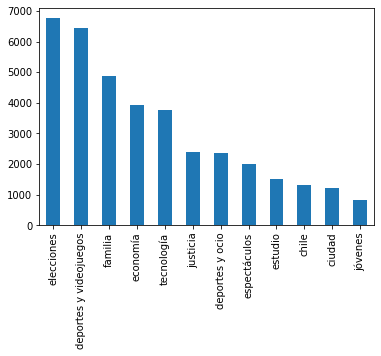

In [71]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go ahead to visualizing them.

In [72]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 67.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=4248953b5d277c6408d1b9dfa3bab11efe9da3a32fa22f8f83e781a16b1e0140
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=b3e77bca851517531c55c96a7cf16a66e718e6f9aca46133a531b21cf514f75d
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [74]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.085868 -0.179740       1        1  15.731374
9     -0.123893 -0.008366       2        1  13.391823
3     -0.185768 -0.091424       3        1  10.896405
6      0.246741  0.006724       4        1  10.700113
4     -0.148286  0.058414       5        1   9.097563
5      0.134264  0.219180       6        1   7.420711
10     0.096596 -0.091523       7        1   6.947018
1     -0.128641  0.135084       8        1   5.796341
7      0.036686  0.093964       9        1   5.700187
11    -0.006084 -0.053739      10        1   5.513783
2      0.033977 -0.082713      11        1   4.417105
8     -0.041461 -0.005862      12        1   4.387581, topic_info=     Category          Freq        Term         Total  loglift  logprob
234   Default  19651.000000       juego  19651.000000  30.0000  30.0000
154   Default  18523.000000  presidente  18523.000000  29.0000  29.0000
809   Default  12317.000000   candidato  12317.000000  28.0000  28.0000
144   Default  15642.000000    millones  15642.000000  27.0000  27.0000
721   Default  11893.000000  elecciones  11893.000000  26.0000  26.0000
...       ...           ...         ...           ...      ...      ...
991   Topic12    691.579895        caso  13979.522461   0.1200  -5.7577
144   Topic12    692.428162    millones  15642.506836   0.0088  -5.7565
1253  Topic12    592.688416    libertad   2755.270020   1.5898  -5.9120
340   Topic12    613.962036    historia  11713.422852   0.1778  -5.8768
49    Topic12    617.807861       lugar  17101.007812  -0.1943  -5.8705

[1039 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
209       3  0.995654      abrigo
777       1  0.031223      acceso
777       2  0.003389      acceso
777       3  0.001694      acceso
777       4  0.237682      acceso
...     ...       ...         ...
9771      9  0.986739       yogur
6036      2  0.047889        your
6036     11  0.950415        your
9794      1  0.996539  zuckerberg
9794      2  0.002085  zuckerberg

[4860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 4, 7, 5, 6, 11, 2, 8, 12, 3, 9])